## Summary

### We first undertake feature selection:
- __Tree and Linear models were fit to assess importance of variables__
    - It is quite erratic for the tree based models, the clear favourite is `age_corr` 
    - The rest is not consistently. I tried with various upsampling.csv files. 
- __Asssess how KNN, SVM and Logistic Regression will perform__ 

### Fitting the Model:
- __stratifiedCV with 5 folds was used.__
- __XBG, RF and ET appear to be consistent best performers__
- __Lasso, OLS and Ridge appear to be consistent, although performing worse.__

### Checking ROC-AUC
- __generally good, and so is the precision-recall curve.__
- __my main concern is overfitting, given my recent submissions.__

### Next Steps
    
- __I tried used only the base features one-hot encoded but it turned out alot worse__
- __We also need to know which upsampling dataset is better. I believe it is \#2, which is the one with smoker_status set to "active" for all null values__

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Tree Based Models

from operator import itemgetter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

# Linear Regression Based Models

from sklearn.linear_model import ElasticNet, HuberRegressor, LinearRegression, Ridge, Lasso, SGDRegressor, PassiveAggressiveRegressor

# Other types

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

# Metrics

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Parallel

from dask.distributed import Client
from sklearn.externals.joblib import parallel_backend
from dask_ml.model_selection import GridSearchCV

# Helper functions

from feature_selection_helper import norm_cols 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
stk = pd.read_csv("../data/train_processed_upsampled2.csv")
stk.head()

,stroke_in_2018,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,0,71.67,36.6,61.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,107.95,30.4,30.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,76.49,42.1,51.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,113.98,57.3,54.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,70.60,26.7,27.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [3]:
stk.shape

(39592, 33)

In [4]:
stk.describe()

,stroke_in_2018,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
count,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,...,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.000000,39592.0
mean,0.166650,112.245483,31.132765,49.073276,0.899424,0.100576,0.428041,0.376642,0.174707,0.309229,...,0.533845,0.122095,0.283972,0.355148,0.238786,0.542938,0.298874,0.151217,0.006971,0.0
std,0.372668,46.361023,7.476227,23.401855,0.300770,0.300770,0.494801,0.484550,0.379721,0.462182,...,0.498859,0.327400,0.450929,0.478564,0.426347,0.498159,0.457770,0.358265,0.083203,0.0
min,0.000000,59.600000,12.600000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,82.290000,26.100000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,96.980000,30.400000,51.469315,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,120.170000,35.200000,68.659560,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0
max,1.000000,295.650000,99.900000,85.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [5]:
X = stk.drop(labels="stroke_in_2018", axis=1).reset_index(drop=True)
y = stk["stroke_in_2018"].reset_index(drop=True)

In [6]:
X.head()

,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,married_1,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,71.67,36.6,61.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,107.95,30.4,30.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,76.49,42.1,51.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,113.98,57.3,54.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,70.60,26.7,27.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: stroke_in_2018, dtype: int64

Let's normalise the variables and see if that helps

In [8]:
X_norm = X.copy()
norm_cols(X_norm, ["average_blood_sugar", "BMI", "age_corr"])

X_norm.head()

,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,married_1,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,0.051133,0.274914,0.707317,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.204829,0.203895,0.329268,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.071553,0.337915,0.585366,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.230375,0.512027,0.621951,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.046600,0.161512,0.292683,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Checking Feature Correlation

Because we have done so much feature engineering, we should remove some of the features that are likely to be correlated. First, we check this with a correlation heatmap.

### Building Base Models

Now we proceed to build base models. We will consider:

- KNN-models, SVM (with penalised regression)
- Linear regression family (OLS, Lasso, Ridge, ElasticNet etc.)
- Tree-based (XGBoost, LGB, RandomForest etc.)

We will look at the ROC-AUC curve to determine the best model, and the F1-score, which considers both precision and recall

### Other Models

Here we consider KNN, SVM and Logistic Regression

In [9]:
other_models = {
    "knn" : KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree'),
#     "svm" : svm.SVC(gamma='scale', probability=True),
    "log" : LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto')
}

### Tree Based Models

In [10]:
tree_based_models = {
    "dt": DecisionTreeRegressor(),
    "rf": RandomForestRegressor(),
    "ada": AdaBoostRegressor(),
    "gb": GradientBoostingRegressor(),
    "et": ExtraTreesRegressor(),
    "xgb": XGBRegressor()
}

Because we are not yet interested in validation, we do not conduct any cross-validation when training the models. The purpose of this is to identify features which are important for 

In [11]:
for _, clf in tree_based_models.items():
    clf.fit(X_norm, y)

[05:59:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [12]:
def generate_sorted_feature_importance(columns_name, feature_importances):
    feature_importance_map = {}
    for i in range(len(columns_name)):
        feature_importance_map[columns_name[i]] = feature_importances[i]
    sorted_feature_importance = dict(sorted(feature_importance_map.items(), key=itemgetter(1)))
    return sorted_feature_importance

def plot_feature_importance(sorted_feature_importance, ax, title):
    num_feature = 20
    bp = sns.barplot(list(sorted_feature_importance.keys())[-num_feature:], list(sorted_feature_importance.values())[-num_feature:], ax=ax)
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
    bp.set_title(title)
    return bp

In [13]:
clf_features_importance = pd.DataFrame()
for name, clf in tree_based_models.items():
    sorted_feature_importance = generate_sorted_feature_importance(X.columns, clf.feature_importances_)
    clf_features_importance[name] = list(sorted_feature_importance.keys())

In [14]:
clf_features_importance[-10:]

,dt,rf,ada,gb,et,xgb
22,married_0,living_area_corr_city,high_sugar,very_high_BMI,senior,medium_BMI
23,job_status_corr_business_owner,job_status_corr_private_sector,smoker_status_quit,job_status_corr_business_owner,very_high_BMI,job_status_corr_private_sector
24,living_area_corr_remote,job_status_corr_business_owner,smoker_status_non_smoker,married_1,job_status_corr_private_sector,job_status_corr_business_owner
25,smoker_status_non_smoker,smoker_status_quit,living_area_corr_remote,senior,smoker_status_active_smoker,smoker_status_active_smoker
26,smoker_status_quit,smoker_status_non_smoker,medium_BMI,BMI,smoker_status_non_smoker,job_status_corr_government
27,smoker_status_active_smoker,smoker_status_active_smoker,married_1,job_status_corr_government,smoker_status_quit,very_high_BMI
28,job_status_corr_government,job_status_corr_government,senior,smoker_status_active_smoker,BMI,married_0
29,BMI,BMI,average_blood_sugar,smoker_status_quit,average_blood_sugar,low_BMI
30,average_blood_sugar,average_blood_sugar,job_status_corr_government,average_blood_sugar,age_corr,smoker_status_quit
31,age_corr,age_corr,age_corr,age_corr,elderly,age_corr


In [15]:
for _, clf in tree_based_models.items():
    clf.fit(X, y)

[06:00:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [16]:
clf_features_importance = pd.DataFrame()
for name, clf in tree_based_models.items():
    sorted_feature_importance = generate_sorted_feature_importance(X.columns, clf.feature_importances_)
    clf_features_importance[name] = list(sorted_feature_importance.keys())

In [17]:
clf_features_importance[-10:]

,dt,rf,ada,gb,et,xgb
22,job_status_corr_business_owner,living_area_corr_city,living_area_corr_remote,very_high_BMI,senior,medium_BMI
23,married_0,job_status_corr_private_sector,senior,job_status_corr_business_owner,job_status_corr_private_sector,job_status_corr_private_sector
24,living_area_corr_city,job_status_corr_business_owner,BMI,married_1,very_high_BMI,job_status_corr_business_owner
25,smoker_status_non_smoker,smoker_status_quit,smoker_status_non_smoker,senior,smoker_status_active_smoker,smoker_status_active_smoker
26,smoker_status_active_smoker,smoker_status_non_smoker,married_1,BMI,smoker_status_quit,job_status_corr_government
27,smoker_status_quit,smoker_status_active_smoker,high_sugar,job_status_corr_government,smoker_status_non_smoker,very_high_BMI
28,job_status_corr_government,job_status_corr_government,smoker_status_active_smoker,smoker_status_active_smoker,BMI,married_0
29,BMI,BMI,average_blood_sugar,smoker_status_quit,average_blood_sugar,low_BMI
30,average_blood_sugar,average_blood_sugar,job_status_corr_government,average_blood_sugar,age_corr,smoker_status_quit
31,age_corr,age_corr,age_corr,age_corr,elderly,age_corr


In [18]:
list(clf_features_importance[-5:].stack().value_counts().items())

[('age_corr', 6),
 ('average_blood_sugar', 5),
 ('job_status_corr_government', 4),
 ('smoker_status_active_smoker', 3),
 ('smoker_status_quit', 3),
 ('BMI', 3),
 ('high_sugar', 1),
 ('smoker_status_non_smoker', 1),
 ('low_BMI', 1),
 ('married_0', 1),
 ('elderly', 1),
 ('very_high_BMI', 1)]

In [19]:
[key for key, val in clf_features_importance[-10:].stack().value_counts().items() if val == 6]

['age_corr', 'smoker_status_active_smoker']

We check up to the $i^{th}$ most important feature, and take the attributes present in all 6 models. 

In [20]:
tree_sc = []
tree_iterations = list(range(5, 33))
for i in tree_iterations:
    tree_model_selected_features = [key for key, val in clf_features_importance[-i:].stack().value_counts().items() if val == 6]
    clf = GradientBoostingRegressor()
    score = np.mean(cross_val_score(clf, X_norm.loc[:, tree_model_selected_features], y, cv=5, scoring="roc_auc"))
    tree_sc.append(score)

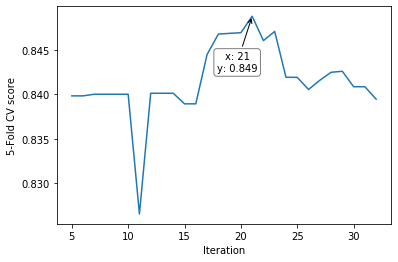

In [21]:
fig, axes = plt.subplots()
sns.lineplot(tree_iterations, tree_sc, ax=axes)
axes.set_xlabel("Iteration")
axes.set_ylabel("5-Fold CV score")
max_x_loc = tree_iterations[tree_sc.index(max(tree_sc))]
max_y_loc = max(tree_sc)
axes.annotate(
    "x: {}\ny: {:.3f}".format(max_x_loc, max_y_loc), xy=(max_x_loc, max_y_loc), xycoords="data", 
    bbox=dict(boxstyle="round", fc="none", ec="gray"),
    xytext=(-15, -55), textcoords="offset points", ha="center", arrowprops=dict(arrowstyle="->")
)
plt.show()

In [22]:
tree_model_best_features = [key for key, val in clf_features_importance[-26:].stack().value_counts().items() if val == 6]
tree_model_best_features

['job_status_corr_government',
 'elderly',
 'smoker_status_active_smoker',
 'age_corr',
 'low_sugar',
 'very_high_BMI',
 'senior',
 'BMI',
 'high_BMI',
 'high_sugar',
 'medium_BMI',
 'medium_sugar',
 'smoker_status_quit',
 'smoker_status_non_smoker',
 'married_0',
 'job_status_corr_private_sector',
 'average_blood_sugar',
 'very_high_sugar']

<div class="alert alert-block alert-warning">
The important features are listed above. It is surprising that `elderly` is not on the list. However, `senior` is, which suggests that perhaps the effect of `elderly` is being masked by one of the other variables
</div>

### Linear Regression Based Models

In [23]:
linear_based_models = {
    "en": ElasticNet(),
    "hr": HuberRegressor(),
    "lr": LinearRegression(),
    "ridge": Ridge(),
    "lasso": Lasso(),
    "sgd": SGDRegressor(), 
    "pa": PassiveAggressiveRegressor()
}

In [24]:
# train all the models at once
for _, clf in linear_based_models.items():
    clf.fit(X, y)

In [25]:
linear_sc = []
linear_iteration = list(range(5, 33))
for i in linear_iteration:
    linear_model_selected_features = [key for key, val in clf_features_importance[-i:].stack().value_counts().items() if val == 6]
    clf = LinearRegression()
    score = np.mean(cross_val_score(clf, X.loc[:, linear_model_selected_features], y, cv=5, scoring="roc_auc"))
    linear_sc.append(score)

In [26]:
linear_model_selected_features

['senior',
 'married_1',
 'has_smoked',
 'high_BP_1',
 'smoker_status_active_smoker',
 'age_corr',
 'low_sugar',
 'heart_condition_detected_2017_1',
 'very_high_BMI',
 'job_status_corr_business_owner',
 'BMI',
 'adult',
 'high_BMI',
 'high_sugar',
 'living_area_corr_city',
 'job_status_corr_government',
 'job_status_corr_parental_leave',
 'elderly',
 'high_BP_0',
 'low_BMI',
 'smoker_status_non_smoker',
 'married_0',
 'child',
 'medium_BMI',
 'very_high_sugar',
 'smoker_status_quit',
 'living_area_corr_remote',
 'average_blood_sugar',
 'job_status_corr_private_sector',
 'job_status_corr_unemployed',
 'heart_condition_detected_2017_0',
 'medium_sugar']

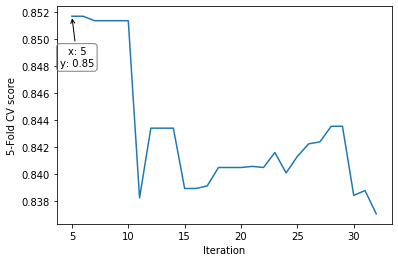

In [27]:
fig, axes = plt.subplots()
sns.lineplot(linear_iteration, linear_sc, ax=axes)
axes.set_xlabel("Iteration")
axes.set_ylabel("5-Fold CV score")
max_x_loc = linear_iteration[linear_sc.index(max(linear_sc))]
max_y_loc = max(linear_sc)
axes.annotate(
    "x: {}\ny: {:.2f}".format(max_x_loc, max_y_loc), xy=(max_x_loc, max_y_loc), xycoords="data", 
    bbox=dict(boxstyle="round", fc="none", ec="gray"),
    xytext=(5, -50), textcoords="offset points", ha="center", arrowprops=dict(arrowstyle="->")
)
plt.show()

In [28]:
linear_model_selected_features

['senior',
 'married_1',
 'has_smoked',
 'high_BP_1',
 'smoker_status_active_smoker',
 'age_corr',
 'low_sugar',
 'heart_condition_detected_2017_1',
 'very_high_BMI',
 'job_status_corr_business_owner',
 'BMI',
 'adult',
 'high_BMI',
 'high_sugar',
 'living_area_corr_city',
 'job_status_corr_government',
 'job_status_corr_parental_leave',
 'elderly',
 'high_BP_0',
 'low_BMI',
 'smoker_status_non_smoker',
 'married_0',
 'child',
 'medium_BMI',
 'very_high_sugar',
 'smoker_status_quit',
 'living_area_corr_remote',
 'average_blood_sugar',
 'job_status_corr_private_sector',
 'job_status_corr_unemployed',
 'heart_condition_detected_2017_0',
 'medium_sugar']

In [29]:
linear_model_best_features = [key for key, val in clf_features_importance[-5:].stack().value_counts().items() if val == 6]
linear_model_best_features


['age_corr']

<div class="alert alert-block alert-warning">
It appears that for linear regression models, `age_corr` is the only variable with strong predictive power. 
</div>

### Finding the Best Model

Now we take a cross-validation approach with both tree and linear models. We use stratified CV to ensure that the ratio of classes are balanced. 

In [30]:
client = Client()
kf = StratifiedKFold(n_splits=5, random_state=99)

In [31]:
def get_cv_score(clf, X, y, kf):
    cv_scores = []
    with parallel_backend("dask"):
        for _, (train_index, test_index) in enumerate(kf.split(X, y)):
            train_X, train_y = X.loc[train_index], y[train_index] 
            test_X, test_y = X.loc[test_index], y[test_index]

            clf.fit(train_X, train_y)
            y_pred = clf.predict(test_X)
            score = roc_auc_score(test_y, y_pred)
            cv_scores.append(score)
        return np.mean(cv_scores)

In [32]:
tree_cv_scores_norm = []
for _, clf in tree_based_models.items():
    cv_score_norm = get_cv_score(clf, X_norm.loc[:, tree_model_best_features], y, kf)
    tree_cv_scores_norm.append(cv_score_norm)

[06:18:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:18:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:18:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:18:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:18:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [33]:
pd.DataFrame({"classifiers": list(tree_based_models.keys()), 
              "CV score": tree_cv_scores_norm}).sort_values("CV score")

,classifiers,CV score
2,ada,0.876522
0,dt,0.912983
5,xgb,0.941972
3,gb,0.942178
4,et,0.969629
1,rf,0.974774


In [34]:
tree_cv_scores = []
for _, clf in tree_based_models.items():
    cv_score = get_cv_score(clf, X.loc[:, tree_model_best_features], y, kf)
    tree_cv_scores.append(cv_score)

[06:19:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:19:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:20:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:20:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:20:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [35]:
pd.DataFrame({"classifiers": list(tree_based_models.keys()), 
              "CV score": tree_cv_scores}).sort_values("CV score")

,classifiers,CV score
2,ada,0.876508
0,dt,0.912528
5,xgb,0.941972
3,gb,0.942175
4,et,0.969656
1,rf,0.973446


Because linear regression only chooses 1 feature, we're going to use all of them. It appears that using more features gives better results in this case

In [36]:
linear_cv_scores = []
for _, clf in linear_based_models.items():
    cv_score = get_cv_score(clf, X.loc[:, linear_model_selected_features], y, kf)
    linear_cv_scores.append(cv_score)

In [37]:
pd.DataFrame({"classifiers": list(linear_based_models.keys()), 
              "CV score": linear_cv_scores}).sort_values("CV score")

,classifiers,CV score
5,sgd,0.528992
1,hr,0.811346
0,en,0.857939
4,lasso,0.858239
6,pa,0.865322
2,lr,0.894992
3,ridge,0.895001


In [38]:
other_cv_scores = []
for _, clf in other_models.items():
    cv_score = get_cv_score(clf, X.loc[:, linear_model_selected_features], y, kf)
    other_cv_scores.append(cv_score)

In [39]:
pd.DataFrame({"classifiers": list(other_models.keys()), 
              "CV score": other_cv_scores}).sort_values("CV score")

,classifiers,CV score
1,log,0.681148
0,knn,0.896319


### Stacking the Model

In [40]:
from copy import deepcopy

class StackingRegressor:
    def __init__(self, models, second_model, features):
        self.models = models
        self.feature_models = []
        self.second_model = second_model
        self.features = features
    
    def _generate_f_features(self, X):
        f_features = np.zeros((X.shape[0], len(self.features) * len(self.models)))
        for num, features in enumerate(self.features * len(self.models)):
            model = self.feature_models[num]
            f_features[:, num] = model.predict(X.loc[:, features[1]])
        return f_features
    
    def fit(self, X, y):
        # generate multiple trained models with different features
        for model in self.models:
            for feature in self.features:
                model.fit(X.loc[:, feature[1]], y)
                self.feature_models.append(deepcopy(model))
        f_features = self._generate_f_features(X)
        self.second_model.fit(f_features, y)
    
    def predict(self, X):
        f_features = self._generate_f_features(X)
        return self.second_model.predict(f_features)

In [41]:
features = [
    ("tree", tree_model_best_features),
    ("linear", linear_model_selected_features)
]

In [42]:
print(get_cv_score(StackingRegressor([
                    GradientBoostingRegressor(), RandomForestRegressor(), AdaBoostRegressor(),
                    ElasticNet(), Ridge(), Lasso()], 
    XGBRegressor(), features), X_norm, y, kf)
     )

[06:22:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:23:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:23:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:24:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9679642000044912


In [43]:
print(get_cv_score(StackingRegressor([
                    GradientBoostingRegressor(), RandomForestRegressor(), AdaBoostRegressor(),
            ], 
    XGBRegressor(), features), X_norm, y, kf)
     )

[06:25:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:28:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9699830890558829


In [44]:
print(get_cv_score(StackingRegressor([
                    GradientBoostingRegressor(), RandomForestRegressor(), AdaBoostRegressor(),
                    Lasso(), LinearRegression(), Ridge(),
                    
            ], 
    XGBRegressor(), features), X_norm, y, kf)
     )

[06:28:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:29:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:30:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:30:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.971535069505693


In [45]:
print(get_cv_score(StackingRegressor([
                    GradientBoostingRegressor(), RandomForestRegressor(),
                    Lasso(), LinearRegression(), PassiveAggressiveRegressor()
            ], 
    XGBRegressor(), features), X_norm, y, kf)
     )

[06:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:32:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:33:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:34:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9765029593276114


In [46]:
print(get_cv_score(StackingRegressor([
                    GradientBoostingRegressor(), RandomForestRegressor(), ExtraTreesRegressor(), 
                    Lasso(), LinearRegression(), PassiveAggressiveRegressor()
            ], 
    XGBRegressor(), features), X_norm, y, kf)
     )

[06:35:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:35:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:36:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:37:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:37:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.971045027483503


In [47]:
get_cv_score(StackingRegressor([
                    ExtraTreesRegressor(), RandomForestRegressor(), 
                    Lasso(), Ridge()
            ], 
    XGBRegressor(), features), X_norm, y, kf)

[06:38:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:38:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:38:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:38:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:38:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9702723093949037

In [48]:
best_models = [
    GradientBoostingRegressor(), RandomForestRegressor(),
    Lasso(), LinearRegression(), 
    KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree'),
    LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto')
]

### Visualising the ROC Curve

We do a simple split and train on the optimal model we found from above and check the ROC curve.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3)

In [50]:
sr = StackingRegressor(best_models, GradientBoostingRegressor(), features)
sr.fit(X_train, y_train) # this was created in section 1.5.1
pred_y = sr.predict(X_test)

In [51]:
pred_y

array([-2.21066574e-04,  8.42966582e-05, -4.88398196e-06, ...,
       -4.88398196e-06, -4.88398196e-06,  2.25617683e-03])

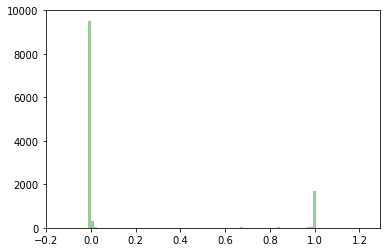

In [52]:
sns.distplot(pred_y, kde = False, bins = 100, color = "green")

NameError: name 'test_y' is not defined

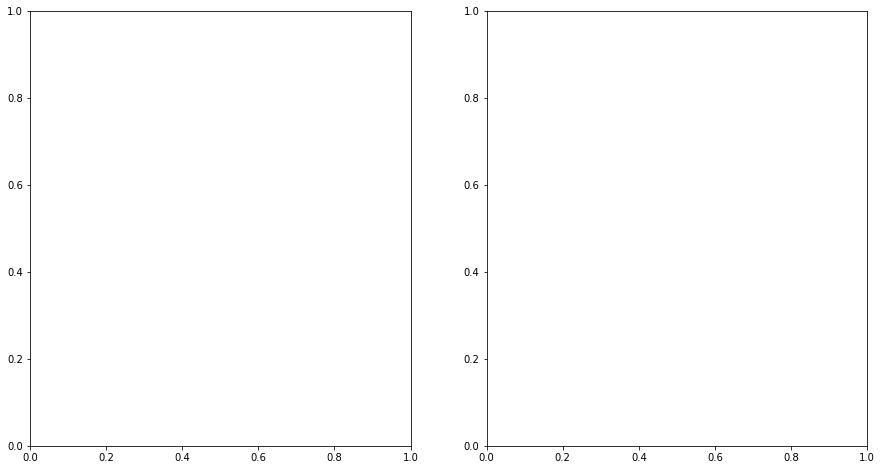

In [53]:
import scikitplot as skplt

fig, axes = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(15)
skplt.metrics.plot_roc(test_y, np.column_stack((1-pred_y, pred_y)), plot_macro=False, plot_micro=False, ax=axes[0])
skplt.metrics.plot_precision_recall(test_y, np.column_stack((1-pred_y, pred_y)), plot_micro=False, ax=axes[1])

In [ ]:
y_result = np.where(y_test > 0.5, 1, 0)
print(classification_report(y_test, y_result, digits=3))

In [ ]:
skplt.metrics.plot_confusion_matrix(test_y, y_result)

### Sandbox Code

code below was for experimentation and may break if you run itm